# BTC Price Analysis

###### Import all dependencies

In [9]:
import requests
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
exec(requests.get('https://raw.githubusercontent.com/NumericCamel/PythonScripts/main/investing_com_btc_clean.py').text)

In [10]:
url = 'https://raw.githubusercontent.com/NumericCamel/PythonScripts/main/investing_com_btc_clean.py'

response = requests.get(url)
script_content = response.text
#print(script_content)

with open('investing_com_btc_clean.py', 'w') as file:
    file.write(script_content)

# Step 2: Import the Saved Script as a Module
import investing_com_btc_clean

In [11]:
btc = pd.read_csv('btc_price.csv')
btc_1 = investing_com_btc_clean.clean_dataset(btc)
btc_1 = btc_1.sort_values(by='Date').reset_index(drop=True)
btc_1

Date    Price     Open     High      Low    Volume  pct_change
0    2018-01-01  13444.9  13850.5  13921.5  12877.7   78430.0     -0.0293
1    2018-01-02  14754.1  13444.9  15306.1  12934.2  137730.0      0.0974
2    2018-01-03  15156.6  14754.1  15435.0  14579.7  106540.0      0.0273
3    2018-01-04  15180.1  15156.5  15408.7  14244.7  110970.0      0.0015
4    2018-01-05  16954.8  15180.1  17126.9  14832.4  141960.0      0.1169
...         ...      ...      ...      ...      ...       ...         ...
2370 2024-06-28  60403.3  61684.6  62175.4  60081.9   58950.0     -0.0208
2371 2024-06-29  60973.4  60403.7  61192.8  60382.8   26560.0      0.0094
2372 2024-06-30  62754.3  60973.1  63006.6  60703.7   37210.0      0.0292
2373 2024-07-01  62890.1  62768.8  63842.1  62558.0   59940.0      0.0022
2374 2024-07-02  62605.5  62888.3  63257.0  62436.4   49250.0     -0.0045

[2375 rows x 7 columns]

In [16]:
from sklearn.cluster import KMeans
def technical_analysis(df):
    # Create a copy of the input DataFrame
    ta = df.copy()
    
    # 10D MA
    ta['MA'] = ta.Price.rolling(window=10).mean()
    ta['MA_td'] = (ta.Price > ta.MA).astype(int)
    
    # 30D MA
    ta['3MA'] = ta.Price.rolling(window=30).mean()
    ta['3MA_td'] = (ta.Price > ta['3MA']).astype(int)
    
    # %K
    lowest_low = ta.Low.rolling(window=10).min()
    highest_high = ta.High.rolling(window=10).max()
    ta['%K'] = (ta.Price - lowest_low) / (highest_high - lowest_low) * 100
    ta['%K_td'] = (ta['%K'] > ta['%K'].shift(1)).astype(int)
    
    # Calculate %D
    ta['%D'] = ta['%K'].rolling(window=3).mean()
    ta['%D_td'] = (ta['%D'] > ta['%D'].shift(1)).astype(int)
    
    # RSI 
    delta = ta.Price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    ta['RSI'] = 100 - (100 / (1 + rs))
    
    def RSI_td(rsi_values):
        if rsi_values >= 70:
            return -1
        elif rsi_values <= 30:
            return 1
        else:
            return 0
    
    ta['RSI_td'] = ta.RSI.apply(RSI_td)
    
    # Momentum 
    momentum_window = 10 
    ta['Momentum'] = ta.Price - ta.Price.shift(momentum_window)
    ta['Momentum_td'] = (ta.Momentum > 1).astype(int)
    
    # MACD 12,26,9
    ta['EMA12'] = ta.Price.ewm(span=12, adjust=False).mean()
    ta['EMA26'] = ta.Price.ewm(span=26, adjust=False).mean()
    ta['MACD'] = ta['EMA12'] - ta['EMA26']
    ta['Signal'] = ta['MACD'].ewm(span=9, adjust=False).mean()
    ta['MACD_td'] = (ta['MACD'] > ta['MACD'].shift(1)).astype(int)
    
    # CCI
    ta['TP'] = (ta['High'] + ta['Low'] + ta['Price']) / 3
    
    # Calculate the 20-period Simple Moving Average of the Typical Price
    ta['SMA_TP'] = ta['TP'].rolling(window=20).mean()
    
    def calculate_md(series):
        return abs(series - series.mean()).mean()
    
    ta['MD'] = ta['TP'].rolling(window=20).apply(calculate_md)
    
    # Calculate the CCI
    ta['CCI'] = (ta['TP'] - ta['SMA_TP']) / (0.015 * ta['MD'])
    
    def CCI_td(CCI_values):
        if CCI_values >= 100:
            return -1
        elif CCI_values <= -100:
            return 1
        else:
            return 0
    
    ta['CCI_td'] = ta.CCI.apply(CCI_td)

    return ta

def bollinger_bands(df, window=20, num_std=2):
    # Calculate the moving average and standard deviation
    df['MA'] = df['Price'].rolling(window=window).mean()
    df['STD'] = df['Price'].rolling(window=window).std()
    
    # Calculate upper and lower Bollinger Bands
    df['Upper'] = df['MA'] + (df['STD'] * num_std)
    df['Lower'] = df['MA'] - (df['STD'] * num_std)
    
    # Calculate Bollinger Bands trend determination
    df['bollinger_bands_td'] = np.nan
    df.loc[df['Price'] > df['Upper'], 'bollinger_bands_td'] = 0  # Sell signal
    df.loc[df['Price'] < df['Lower'], 'bollinger_bands_td'] = 1  # Buy signal
    
    # Forward fill the signals
    df['bollinger_bands_td'] = df['bollinger_bands_td'].ffill()
    
    return df

btc_ta = technical_analysis(btc_1)
btc_ta = bollinger_bands(btc_ta)
btc_ta

Date    Price     Open     High      Low    Volume  pct_change  \
0    2018-01-01  13444.9  13850.5  13921.5  12877.7   78430.0     -0.0293   
1    2018-01-02  14754.1  13444.9  15306.1  12934.2  137730.0      0.0974   
2    2018-01-03  15156.6  14754.1  15435.0  14579.7  106540.0      0.0273   
3    2018-01-04  15180.1  15156.5  15408.7  14244.7  110970.0      0.0015   
4    2018-01-05  16954.8  15180.1  17126.9  14832.4  141960.0      0.1169   
...         ...      ...      ...      ...      ...       ...         ...   
2370 2024-06-28  60403.3  61684.6  62175.4  60081.9   58950.0     -0.0208   
2371 2024-06-29  60973.4  60403.7  61192.8  60382.8   26560.0      0.0094   
2372 2024-06-30  62754.3  60973.1  63006.6  60703.7   37210.0      0.0292   
2373 2024-07-01  62890.1  62768.8  63842.1  62558.0   59940.0      0.0022   
2374 2024-07-02  62605.5  62888.3  63257.0  62436.4   49250.0     -0.0045   

             MA  MA_td           3MA  ...  MACD_td            TP  \
0           NaN      0           NaN  ...        0  13414.700000   
1           NaN      0           NaN  ...        1  14331.466667   
2           NaN      0           NaN  ...        1  15057.100000   
3           NaN      0           NaN  ...        1  14944.500000   
4           NaN      0           NaN  ...        1  16304.700000   
...         ...    ...           ...  ...      ...           ...   
2370  64929.700      0  66330.110000  ...        0  60886.866667   
2371  64495.840      0  66084.066667  ...        0  60849.666667   
2372  64156.645      1  65924.873333  ...        1  62154.866667   
2373  63935.160      1  65762.516667  ...        1  63096.733333   
2374  63652.430      1  65590.250000  ...        1  62766.300000   

            SMA_TP           MD         CCI  CCI_td          STD  \
0              NaN          NaN         NaN       0          NaN   
1              NaN          NaN         NaN       0          NaN   
2              NaN          NaN         NaN       0          NaN   
3              NaN          NaN         NaN       0          NaN   
4              NaN          NaN         NaN       0          NaN   
...            ...          ...         ...     ...          ...   
2370  65069.710000  2249.491333 -123.964124       1  2857.908004   
2371  64634.941667  2280.204167 -110.670645       1  2760.490497   
2372  64260.175000  2153.445000  -65.176445       0  2514.090294   
2373  64030.163333  2055.417000  -30.275446       0  2413.883361   
2374  63749.105000  1900.745000  -34.470870       0  2202.558194   

             Upper         Lower  bollinger_bands_td  
0              NaN           NaN                 NaN  
1              NaN           NaN                 NaN  
2              NaN           NaN                 NaN  
3              NaN           NaN                 NaN  
4              NaN           NaN                 NaN  
...            ...           ...                 ...  
2370  70645.516008  59213.883992                 1.0  
2371  70016.820994  58974.859006                 1.0  
2372  69184.825589  59128.464411                 1.0  
2373  68762.926722  59107.393278                 1.0  
2374  68057.546388  59247.313612                 1.0  

[2375 rows x 33 columns]

### K-Means Clustering to find support and resistance levels

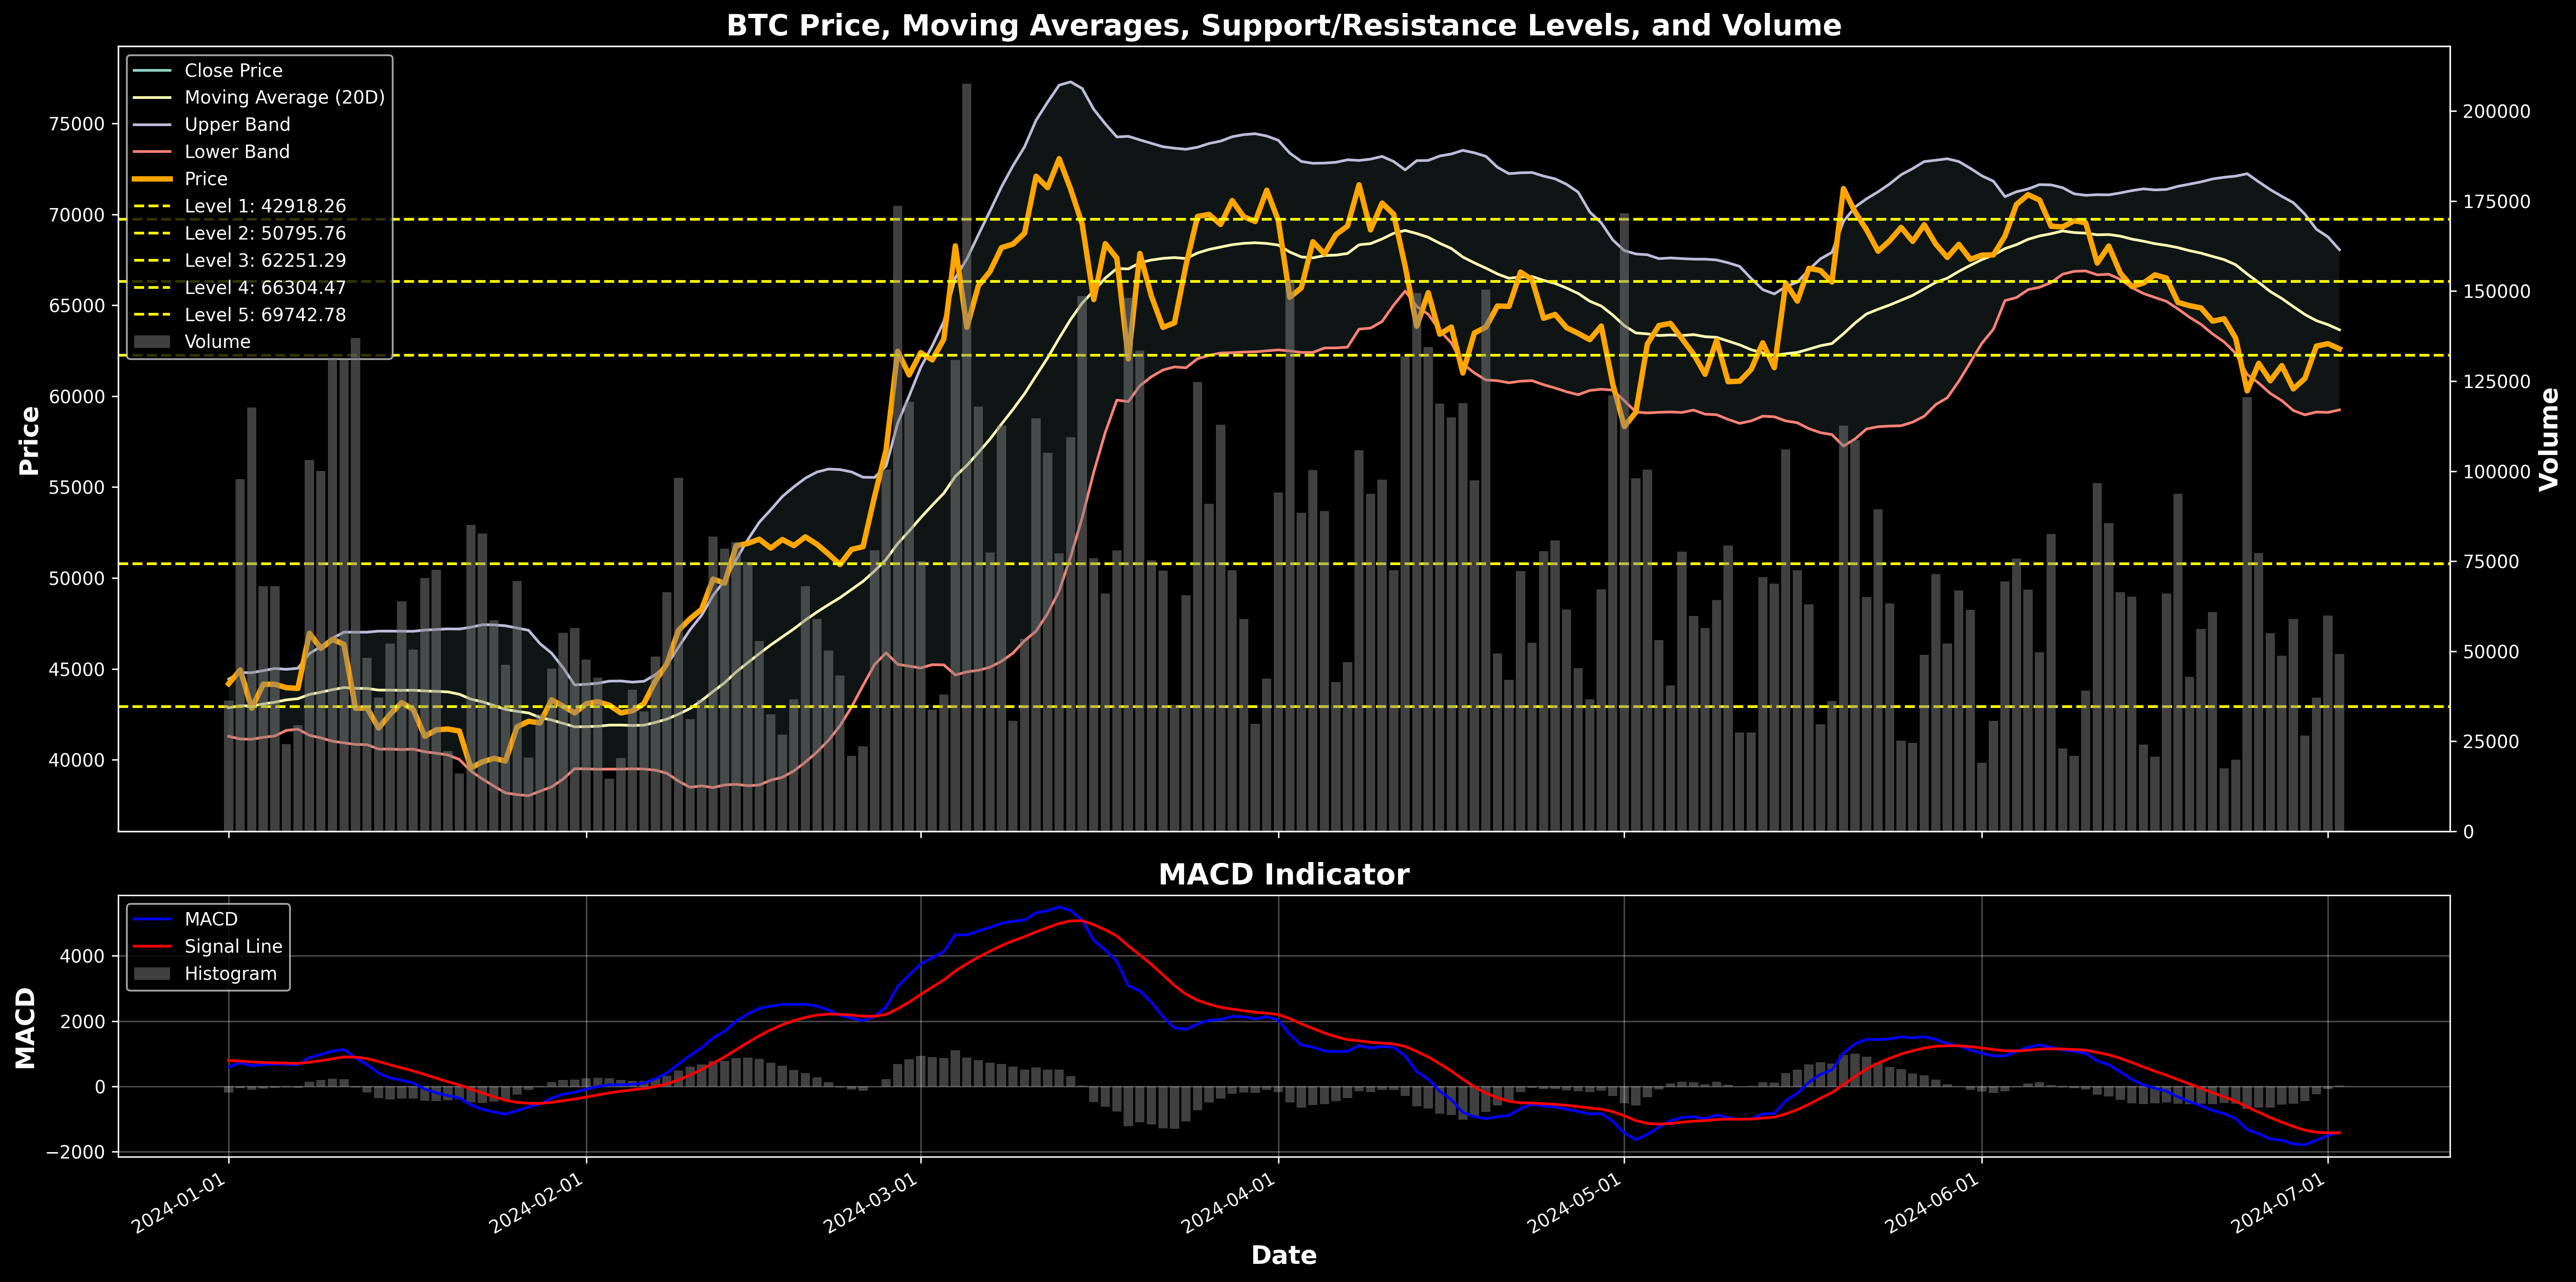

In [25]:
import matplotlib.dates as mdates


# Filter the data for the year 2024
btc_graph = btc_ta[(btc_ta['Date'].dt.year == 2024) & (btc_ta['Date'].dt.month >= 1)]

# Extract the 'Price' column for clustering
prices = btc_graph['Price'].values.reshape(-1, 1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
kmeans.fit(prices)

# Get cluster centers (these can be considered as potential support/resistance levels)
cluster_centers = kmeans.cluster_centers_.flatten()

# Sort the levels for better readability
sorted_centers = sorted(cluster_centers)

# Create a DataFrame for the support and resistance levels with sorted names
support_resistance_df = pd.DataFrame({
    'Level': sorted_centers,
    'Type': [f'Level {i+1}' for i in range(len(sorted_centers))]
})

# Set the style
plt.style.use('dark_background')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# First subplot: Price, Moving Averages, Support/Resistance Levels, and Volume

#ax1.plot(btc_graph.Date, btc_graph.MA, label='Moving Average (10D)', color='#00FFFF', linewidth=2)
#ax1.plot(btc_graph.Date, btc_graph['3MA'], label='Moving Average (30D)', color='#FF00FF', linewidth=2)
ax1.plot(btc_graph['Date'], btc_graph['Price'], label='Close Price')
ax1.plot(btc_graph['Date'], btc_graph['MA'], label='Moving Average (20D)')
ax1.plot(btc_graph['Date'], btc_graph['Upper'], label='Upper Band')
ax1.plot(btc_graph['Date'], btc_graph['Lower'], label='Lower Band')
ax1.fill_between(btc_graph['Date'], btc_graph['Upper'], btc_graph['Lower'], alpha=0.1)
ax1.plot(btc_graph.Date, btc_graph.Price, label='Price', color='orange', linewidth=3)

for i, center in enumerate(sorted_centers):
    ax1.axhline(y=center, color='#FFFF00', linestyle='--', label=f'Level {i+1}: {center:.2f}', linewidth=1.5)

ax1.set_ylabel('Price', fontsize=14, fontweight='bold', color='white')
ax1.set_title('BTC Price, Moving Averages, Support/Resistance Levels, and Volume', fontsize=16, fontweight='bold', color='white')
ax1.legend(loc='upper left', fontsize=10)

# Volume on the same subplot
ax1_volume = ax1.twinx()
ax1_volume.bar(btc_graph.Date, btc_graph.Volume, color='#808080', alpha=0.5, label='Volume')
ax1_volume.set_ylabel('Volume', fontsize=14, fontweight='bold', color='white')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_volume.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)

# Second subplot: MACD
ax2.plot(btc_graph['Date'], btc_graph['MACD'], label='MACD', color='blue')
ax2.plot(btc_graph['Date'], btc_graph['Signal'], label='Signal Line', color='red')
ax2.bar(btc_graph['Date'], btc_graph['MACD'] - btc_graph['Signal'], label='Histogram', color='gray', alpha=0.5)

ax2.set_title('MACD Indicator', fontsize=16, fontweight='bold', color='white')
ax2.set_xlabel('Date', fontsize=14, fontweight='bold', color='white')
ax2.set_ylabel('MACD', fontsize=14, fontweight='bold', color='white')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Format x-axis
plt.gcf().autofmt_xdate()  # Rotation
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax2.xaxis.set_major_formatter(myFmt)

# Adjust layout
plt.tight_layout()

# Show the combined chart
plt.show()

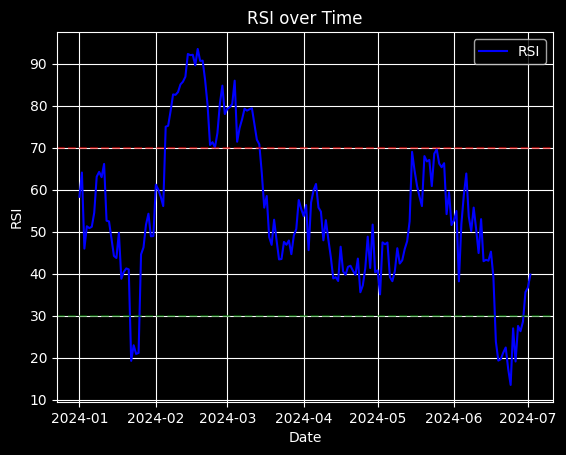

In [26]:
plt.plot(btc_graph['Date'], btc_graph['RSI'], label='RSI', color='blue')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')
plt.axhline(30, linestyle='--', alpha=0.5, color='green')
plt.title('RSI over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
import matplotlib.dates as mdates
import matplotlib.image as mpimg


# Filter the data for the year 2024
btc_graph = btc_ta[(btc_ta['Date'].dt.year == 2024) & (btc_ta['Date'].dt.month >= 1)]

# Extract the 'Price' column for clustering
prices = btc_graph['Price'].values.reshape(-1, 1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
kmeans.fit(prices)

# Get cluster centers (these can be considered as potential support/resistance levels)
cluster_centers = kmeans.cluster_centers_.flatten()

# Sort the levels for better readability
sorted_centers = sorted(cluster_centers)

# Create a DataFrame for the support and resistance levels with sorted names
support_resistance_df = pd.DataFrame({
    'Level': sorted_centers,
    'Type': [f'Level {i+1}' for i in range(len(sorted_centers))]
})

# Set the style
plt.style.use('dark_background')

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(40, 20), dpi=300, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# First subplot: Price, Moving Averages, Support/Resistance Levels, and Volume

#ax1.plot(btc_graph.Date, btc_graph.MA, label='Moving Average (10D)', color='#00FFFF', linewidth=2)
#ax1.plot(btc_graph.Date, btc_graph['3MA'], label='Moving Average (30D)', color='#FF00FF', linewidth=2)
ax1.plot(btc_graph['Date'], btc_graph['Price'], label='Close Price')
ax1.plot(btc_graph['Date'], btc_graph['MA'], label='Moving Average (20D)')
ax1.plot(btc_graph['Date'], btc_graph['Upper'], label='Upper Band')
ax1.plot(btc_graph['Date'], btc_graph['Lower'], label='Lower Band')
ax1.fill_between(btc_graph['Date'], btc_graph['Upper'], btc_graph['Lower'], alpha=0.1)
ax1.plot(btc_graph.Date, btc_graph.Price, label='Price', color='orange', linewidth=3)

for i, center in enumerate(sorted_centers):
    ax1.axhline(y=center, color='#FFFF00', linestyle='--', label=f'Level {i+1}: {center:.2f}', linewidth=1.5)

ax1.set_ylabel('Price', fontsize=14, fontweight='bold', color='white')
ax1.set_title('BTC Price, Moving Averages, Support/Resistance Levels, and Volume', fontsize=16, fontweight='bold', color='white')
ax1.legend(loc='upper left', fontsize=10)

# Volume on the same subplot
ax1_volume = ax1.twinx()
ax1_volume.bar(btc_graph.Date, btc_graph.Volume, color='#808080', alpha=0.5, label='Volume')
ax1_volume.set_ylabel('Volume', fontsize=14, fontweight='bold', color='white')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_volume.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=10)

# Second subplot: MACD
ax2.plot(btc_graph['Date'], btc_graph['MACD'], label='MACD', color='blue')
ax2.plot(btc_graph['Date'], btc_graph['Signal'], label='Signal Line', color='red')
ax2.bar(btc_graph['Date'], btc_graph['MACD'] - btc_graph['Signal'], label='Histogram', color='gray', alpha=0.5)

ax2.set_title('MACD Indicator', fontsize=16, fontweight='bold', color='white')
ax2.set_xlabel('Date', fontsize=14, fontweight='bold', color='white')
ax2.set_ylabel('MACD', fontsize=14, fontweight='bold', color='white')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

ax3.plot(btc_graph['Date'], btc_graph['RSI'], label='RSI', color='blue')
ax3.axhline(70, linestyle='--', alpha=0.5, color='red')
ax3.axhline(30, linestyle='--', alpha=0.5, color='green')
ax3.set_title('RSI over Time', fontsize=16, fontweight='bold', color='white')
ax3.set_xlabel('Date', fontsize=14, fontweight='bold', color='white')
ax3.set_ylabel('RSI', fontsize=14, fontweight='bold', color='white')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

# Format x-axis
plt.gcf().autofmt_xdate()  # Rotation
myFmt = mdates.DateFormatter('%Y-%m-%d')
ax2.xaxis.set_major_formatter(myFmt)

# Adjust layout
plt.tight_layout()

# Add watermark image
img = mpimg.imread('tweet_outputs/camel.jpg')  # Replace with the path to your watermark image
fig.figimage(
    img,
    xo=fig.bbox.xmax - img.shape[1] - 10,  # 10 pixels from the right edge
    yo=10,  # 10 pixels from the bottom edge
    alpha=1,
    zorder=1
)

# Show the combined chart
plt.show()

### LSTM Prediction of next 14 days

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3780
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015
Epoch 13/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019
Epoch 14/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013
Epoch 15/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012
E

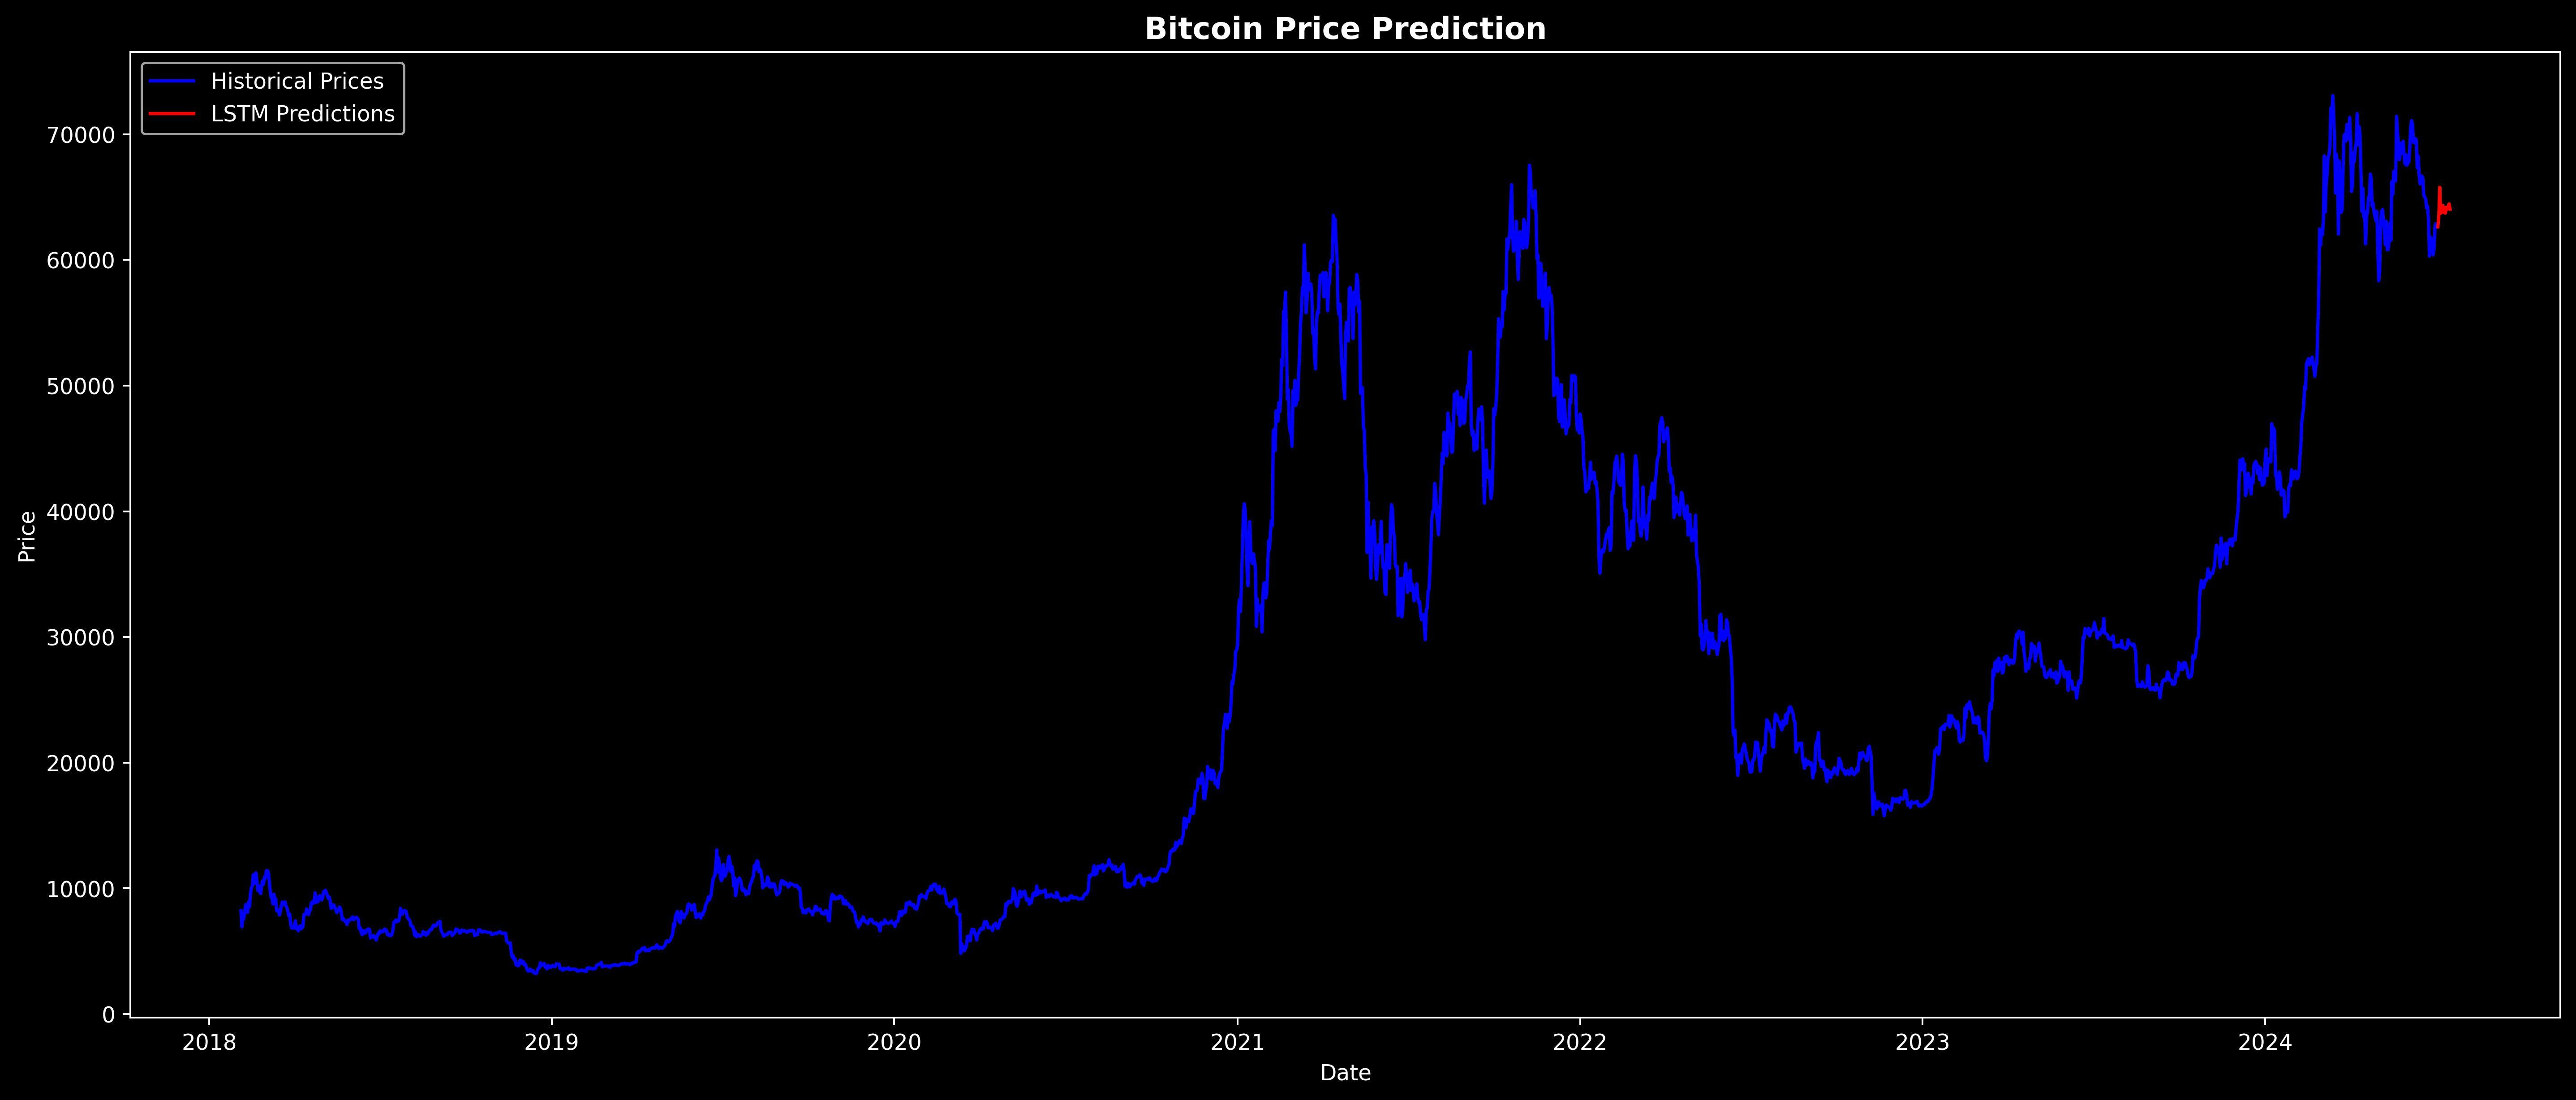

73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 546.12


In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
btc_mo = btc_ta.copy()
btc_mo = btc_mo.dropna()
btc_mo['Date'] = pd.to_datetime(btc_mo['Date'])
btc_mo.set_index('Date', inplace=True)

# Select features for training
features = ['Price', 'Open', 'High', 'Low', 'Volume', 'pct_change', 'MA',
       'MA_td', '3MA', '3MA_td', '%K', '%K_td', '%D', '%D_td', 'RSI', 'RSI_td',
       'Momentum', 'Momentum_td', 'EMA12', 'EMA26', 'MACD', 'Signal',
       'MACD_td', 'TP', 'SMA_TP', 'MD', 'CCI', 'CCI_td']

data = btc_mo[features].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        if not np.isnan(seq).any() and not np.isnan(data[i + seq_length, 0]):
            X.append(seq)
            y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 24  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Build the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, len(features))),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model on all available data
model.fit(X, y, batch_size=32, epochs=100, verbose=1)

# Predict the next 14 days
last_sequence = scaled_data[-seq_length:]
predicted_prices = []

for _ in range(14):
    next_pred = model.predict(last_sequence.reshape(1, seq_length, len(features)))
    predicted_prices.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1] = next_pred

# Inverse transform the predictions
predicted_prices = scaler.inverse_transform(np.column_stack((predicted_prices, np.zeros((14, len(features)-1)))))[:, 0]

# Visualize the results
plt.figure(figsize=(20, 8), dpi = 350)
plt.plot(btc_mo.index, btc_mo['Price'], label='Historical Prices', color='blue')
future_dates = pd.date_range(start=btc_mo.index[-1] + pd.Timedelta(days=1), periods=14)
plt.plot(future_dates, predicted_prices, label='LSTM Predictions', color='red')
plt.title('Bitcoin Price Prediction', fontweight = 'bold', fontsize = 14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE for the training data
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros((len(train_predict), len(features)-1)))))[:, 0]
y_actual = scaler.inverse_transform(np.column_stack((y.reshape(-1, 1), np.zeros((len(y), len(features)-1)))))[:, 0]
rmse = np.sqrt(mean_squared_error(y_actual, train_predict))
print(f"Training RMSE: {rmse:.2f}")

C:\Users\mulle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\mulle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\mulle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packag

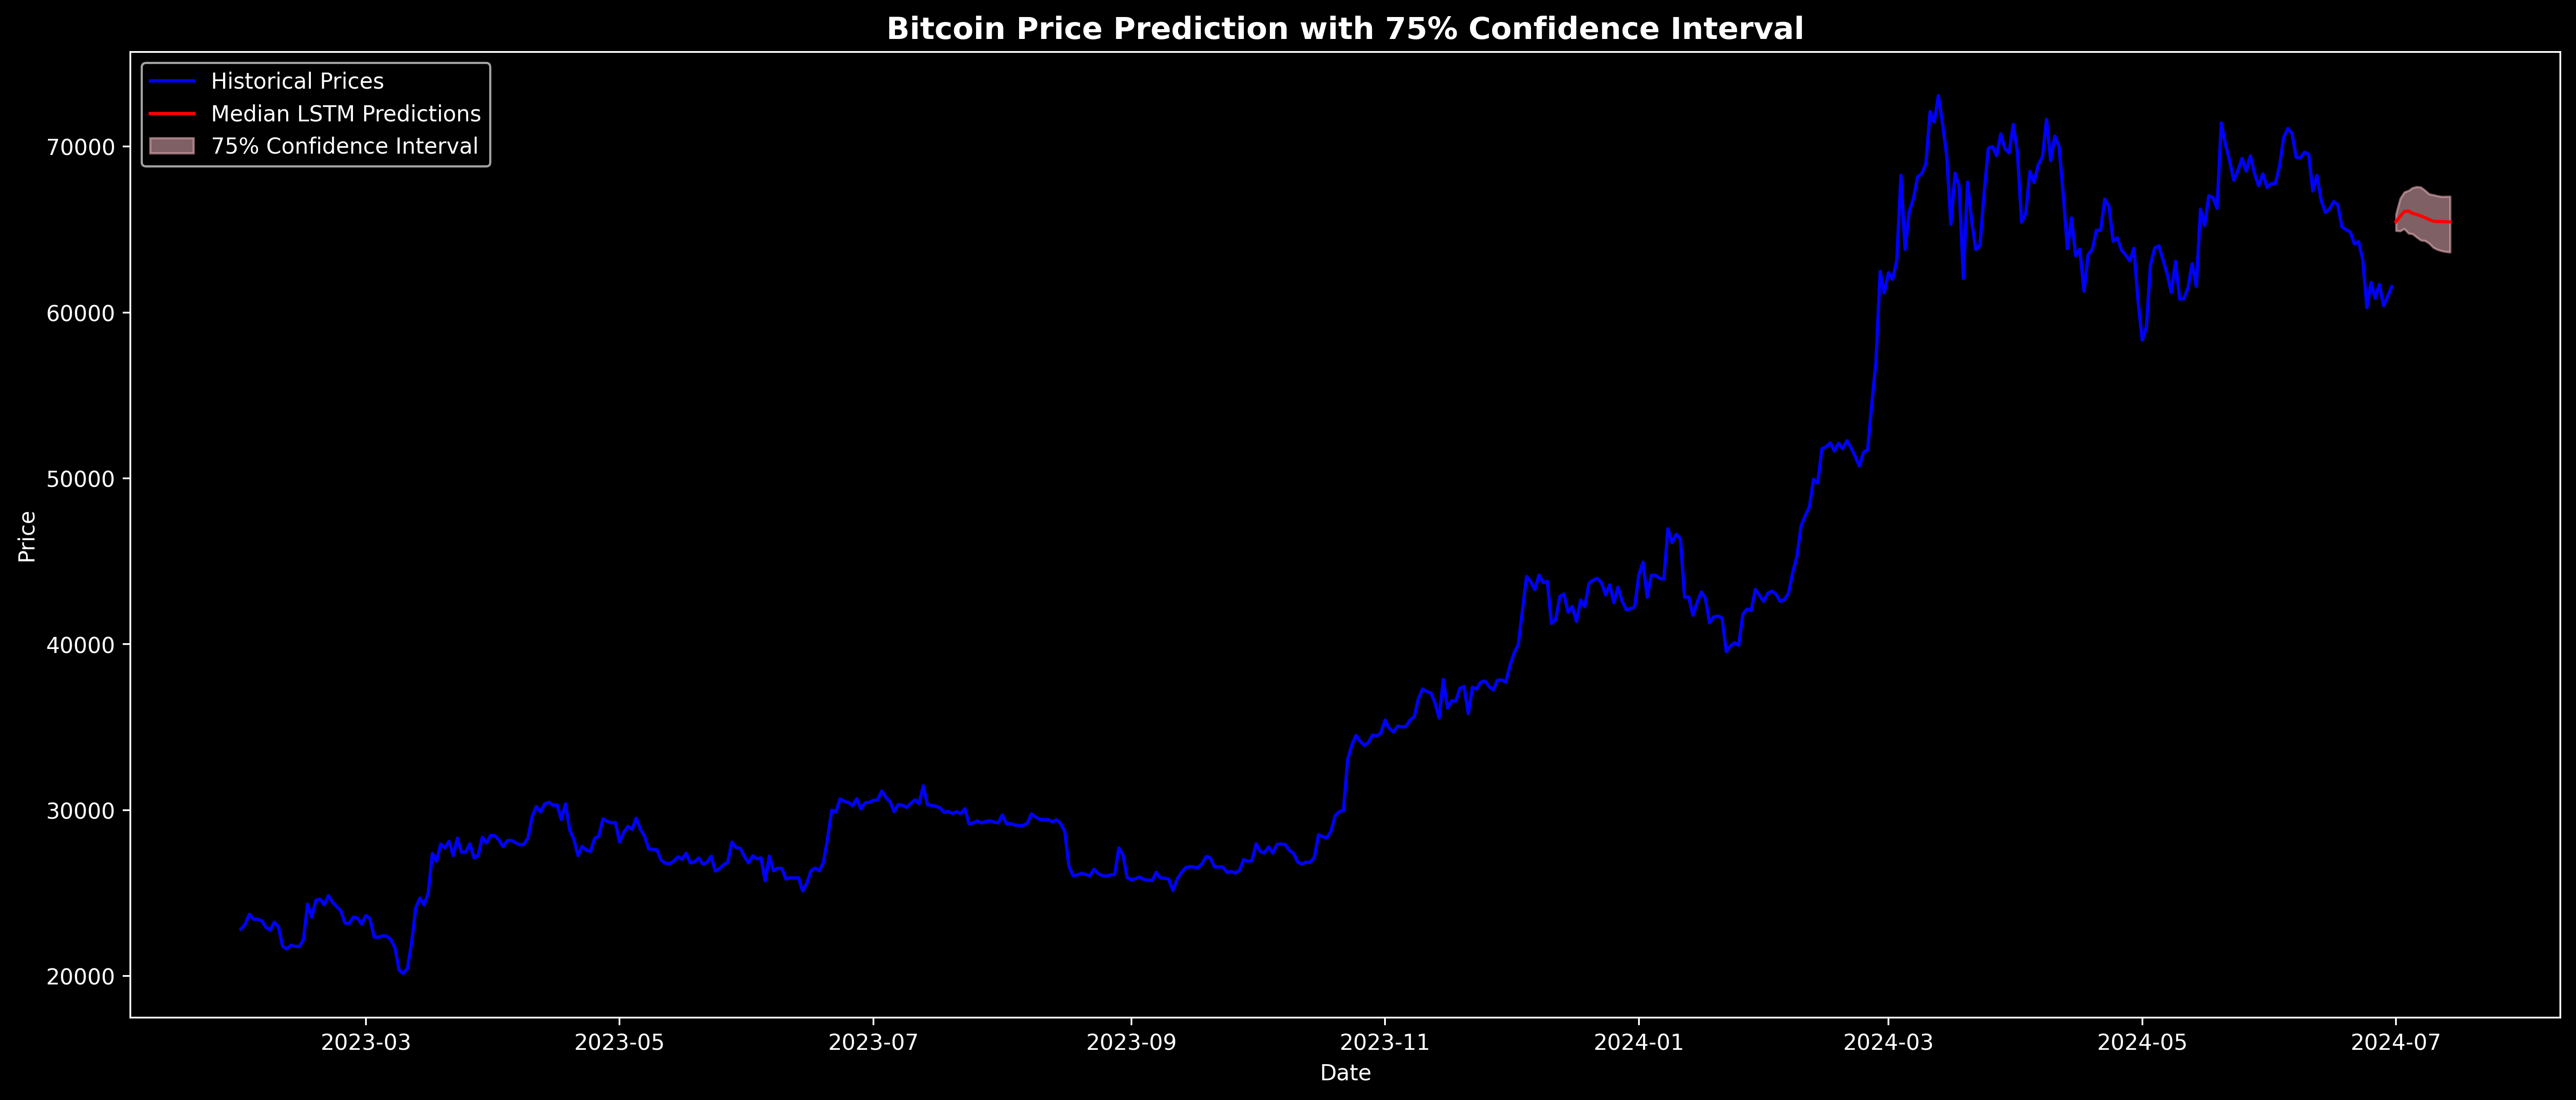

Training RMSE: 2187.79


In [123]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load and preprocess data
btc_mo = btc_ta.copy()
btc_mo = btc_mo.dropna()
btc_mo['Date'] = pd.to_datetime(btc_mo['Date'])
btc_mo.set_index('Date', inplace=True)

# Select features for training
features = ['Price', 'Open', 'High', 'Low', 'Volume', 'pct_change', 'MA',
       'MA_td', '3MA', '3MA_td', '%K', '%K_td', '%D', '%D_td', 'RSI', 'RSI_td',
       'Momentum', 'Momentum_td', 'EMA12', 'EMA26', 'MACD', 'Signal',
       'MACD_td', 'TP', 'SMA_TP', 'MD', 'CCI', 'CCI_td']

data = btc_mo[features].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        if not np.isnan(seq).any() and not np.isnan(data[i + seq_length, 0]):
            X.append(seq)
            y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

# Convert data to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(device)
        _, (hn, _) = self.lstm(x, (h_0, c_0))
        out = self.linear(hn[-1])
        return out

input_size = len(features)
hidden_layer_size = 50
output_size = 1

model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, X, y, epochs=100, batch_size=32):
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

# Run the model multiple times and store predictions
n_bootstraps = 100
predictions = []

for i in range(n_bootstraps):
    model = LSTMModel(input_size, hidden_layer_size, output_size).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_model(model, X, y, epochs=100, batch_size=32)
    
    # Predict the next 14 days
    last_sequence = torch.tensor(scaled_data[-seq_length:], dtype=torch.float32).unsqueeze(0).to(device)
    predicted_prices = []

    for _ in range(14):
        next_pred = model(last_sequence)
        predicted_prices.append(next_pred.item())
        last_sequence = torch.roll(last_sequence, -1, dims=1)
        last_sequence[0, -1] = next_pred

    # Inverse transform the predictions
    predicted_prices = scaler.inverse_transform(np.column_stack((predicted_prices, np.zeros((14, len(features)-1)))))[:, 0]
    predictions.append(predicted_prices)

predictions = np.array(predictions)

# Calculate 75% confidence intervals
lower_bound = np.percentile(predictions, 12.5, axis=0)
upper_bound = np.percentile(predictions, 87.5, axis=0)
median_prediction = np.median(predictions, axis=0)

# Visualize the results
plt.figure(figsize=(20, 8), dpi=350)
plt.plot(btc_mo.index, btc_mo['Price'], label='Historical Prices', color='blue')
future_dates = pd.date_range(start=btc_mo.index[-1] + pd.Timedelta(days=1), periods=14)
plt.plot(future_dates, median_prediction, label='Median LSTM Predictions', color='red')
plt.fill_between(future_dates, lower_bound, upper_bound, color='pink', alpha=0.5, label='75% Confidence Interval')
plt.title('Bitcoin Price Prediction with 75% Confidence Interval', fontweight='bold', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate RMSE for the training data
model.eval()
with torch.no_grad():
    train_predict = model(X).cpu().numpy()
    train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros((len(train_predict), len(features)-1)))))[:, 0]
    y_actual = scaler.inverse_transform(np.column_stack((y.cpu().numpy().reshape(-1, 1), np.zeros((len(y), len(features)-1)))))[:, 0]
    rmse = np.sqrt(mean_squared_error(y_actual, train_predict))
    print(f"Training RMSE: {rmse:.2f}")
